## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

**Installation of Spacy**

In [1]:
# installation of Spacy - for 10x faster data cleaning with accuracy and scalability
!pip install numpy==1.26.4
!pip install spacy==3.7.4 --no-deps
!python -m spacy download en_core_web_sm
!pip install wordcloud

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.2/12.8 MB 7.3 MB/s eta 0:00:02
     - -------------------------------------- 0.5/12.8 MB 4.7 MB/s eta 0:00:03
     - -------------------------------------- 0.6/12.8 MB 4.2 MB/s eta 0:00:03
     -- ------------------------------------- 0.8/12.8 MB 4.3 MB/s eta 0:00:03
     -- ------------------------------------- 0.9/12.8 MB 4.0 MB/s eta 0:00:03
     --- ------------------------------------ 1.0/12.8 MB 3.7 MB/s eta 0:00:04
     --- ------------------------------------ 1.1/12.8 MB 3.4 MB/s eta 0:00:04
     --- ------------------------------------ 1.2/12.8 MB 3.2 MB/s eta 0:00:04
     --- ------------------------------------ 1.3/12.8 MB 3.0 MB/s eta 0:00:04
     ---- ----------------------------------- 1.3/12.8 MB 2.8 MB/s eta 0:00:05
     ---- ----------------------------------- 1.4/12.8 MB 2.6 MB/s eta 0:00:05
     ---- ----------------------------------- 1.4/12.8 MB 2

## Importing the necessary libraries

In [128]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import joblib
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
from tqdm import tqdm
from wordcloud import WordCloud
import plotly.graph_objects as go
import plotly.express as px
from sklearn.metrics import confusion_matrix

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

**Load Spacy**

In [116]:
# Load the English language model
nlp = spacy.load("en_core_web_sm")

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [118]:
# Opening JSON file 
f = open("complaints-2021-05-14_08_16.json", "r")

# returns JSON object as a dictionary 
data = json.load(f)
df = pd.json_normalize(data)

# Display shape and first few rows
print("Data shape:", df.shape)
df.head()

Data shape: (78313, 22)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


## Data preparation

In [9]:
# Inspect the dataframe to understand the given data.

# Check column names and types
print(df.info())

# Display first 5 rows
print(df.head())

# Check for missing values
print(df.isnull().sum())

# Display basic statistics for numeric columns
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [11]:
# Print the column names
print(df.columns.tolist())

['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code', '_source.complaint_id', '_source.issue', '_source.date_received', '_source.state', '_source.consumer_disputed', '_source.product', '_source.company_response', '_source.company', '_source.submitted_via', '_source.date_sent_to_company', '_source.company_public_response', '_source.sub_product', '_source.timely', '_source.complaint_what_happened', '_source.sub_issue', '_source.consumer_consent_provided']


In [13]:
# Assign new column names
df.columns = [
    'index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id', 
    'issue', 'date_received', 'state', 'consumer_disputed', 'product', 
    'company_response', 'company', 'submitted_via', 'date_sent_to_company', 
    'company_public_response', 'sub_product', 'timely', 
    'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'
]

# Verify the new column names
print(df.columns.tolist())

['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id', 'issue', 'date_received', 'state', 'consumer_disputed', 'product', 'company_response', 'company', 'submitted_via', 'date_sent_to_company', 'company_public_response', 'sub_product', 'timely', 'complaint_what_happened', 'sub_issue', 'consumer_consent_provided']


In [15]:
#Assign nan in place of blanks in the complaints column

df['complaint_what_happened'] = df['complaint_what_happened'].replace('', np.nan)

# Verify changes
df['complaint_what_happened'].isna().sum()

57241

In [17]:
#Remove all rows where complaints column is nan
df = df.dropna(subset=['complaint_what_happened'])

# Verify the new shape
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [19]:
# Write your function here to clean the text and remove all the unnecessary elements.

def clean_text(text):
    # Make text lowercase
    text = text.lower()
    
    # Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    return text

In [21]:
#Write your function to Lemmatize the texts

def lemmatize_text(text):
    doc = nlp(text)
    lemmatized = [token.lemma_ for token in doc]
    return ' '.join(lemmatized)

In [23]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints

df_clean = pd.DataFrame()
df_clean['complaints'] = df['complaint_what_happened']

texts = df_clean['complaints'].fillna("").tolist()
lemmatized_texts = []

# Use spaCy's nlp.pipe with tqdm to show progress
for doc in tqdm(nlp.pipe(texts, batch_size=1000, disable=["parser", "ner"]), total=len(texts)):
    lemmas = [token.lemma_ for token in doc if token.is_alpha]
    lemmatized_texts.append(" ".join(lemmas))

df_clean['lemmatized_complaints'] = lemmatized_texts

# Display the first few rows to verify
df_clean.head()

100%|████████████████████████████████████████████████████████████████████████████| 21072/21072 [05:58<00:00, 58.77it/s]


,complaints,lemmatized_complaints
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be XXXX XXXX and I apprec...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in XX and be tell ...
10,Chase Card was reported on XX/XX/2019. However...,Chase Card be report on XX however fraudulent ...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on XX while try to book a XXXX xxxx ticket I c...
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it int...


In [25]:
df_clean

,complaints,lemmatized_complaints
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be XXXX XXXX and I apprec...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in XX and be tell ...
10,Chase Card was reported on XX/XX/2019. However...,Chase Card be report on XX however fraudulent ...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on XX while try to book a XXXX xxxx ticket I c...
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it int...
...,...,...
78303,After being a Chase Card customer for well ove...,after be a Chase Card customer for well over a...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on Wednesday XX XX XXXX I call Chas my xxxx xx...
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...
78311,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for yrs I have Cha...


In [27]:
tqdm.pandas()

#Write your function to extract the POS tags 

def pos_tag(text):
  # write your code here
    if not isinstance(text, str) or text.strip() == "":
        return ""
    doc = nlp(text, disable=["parser", "ner"])  # speed boost
    nouns = [token.lemma_ for token in doc if token.pos_ == "NOUN"]  # Keep only nouns (NN)
    return " ".join(nouns)

df_clean["complaint_POS_removed"] = df_clean["lemmatized_complaints"].progress_apply(pos_tag) #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].

100%|████████████████████████████████████████████████████████████████████████████| 21072/21072 [04:00<00:00, 87.61it/s]


In [29]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaints,lemmatized_complaints,complaint_POS_removed
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be XXXX XXXX and I apprec...,morning name stop cardmember service debt veri...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in XX and be tell ...,xxxx card agent anniversary date agent informa...
10,Chase Card was reported on XX/XX/2019. However...,Chase Card be report on XX however fraudulent ...,report application identity consent service cr...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on XX while try to book a XXXX xxxx ticket I c...,xxxx xxxx ticket offer ticket reward card info...
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...
...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a Chase Card customer for well over a...,customer decade solicitation credit card bonus...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on Wednesday XX XX XXXX I call Chas my xxxx xx...,xxxx xxxx provider claim purchase protection b...
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...,xxxx risk consumer bank app year banking merch...
78311,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for yrs I have Cha...,credit yrs credit card problem balance transfe...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




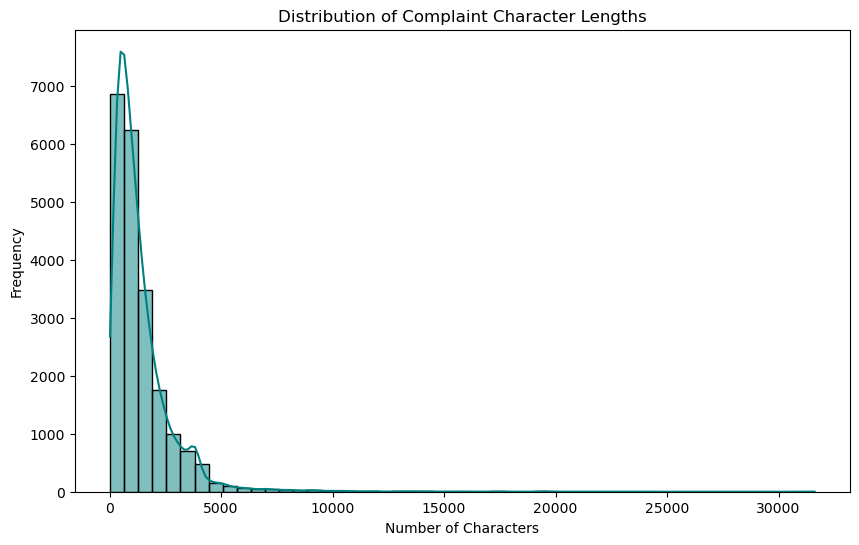

In [31]:
# Write your code here to visualise the data according to the 'Complaint' character length

# Create a new column for complaint character length
df_clean['complaint_length'] = df_clean['complaints'].astype(str).apply(len)

# Plot the distribution of complaint lengths
plt.figure(figsize=(10,6))
sns.histplot(df_clean['complaint_length'], bins=50, kde=True, color='teal')
plt.title("Distribution of Complaint Character Lengths")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

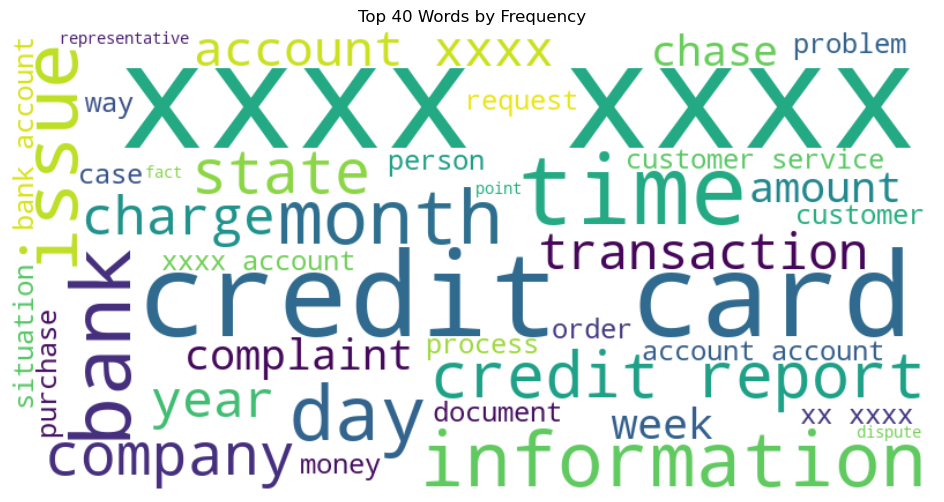

In [33]:
# Using a word cloud find the top 40 words by frequency among all the articles after processing the text

# Combine all the complaint text into one string
all_words = " ".join(df_clean['complaint_POS_removed'].dropna().astype(str))

# Create the word cloud
wordcloud = WordCloud(width=800, height=400, max_words=40, background_color='white', colormap='viridis').generate(all_words)

# Display the word cloud
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Top 40 Words by Frequency")
plt.show()

In [35]:
# Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '', regex=False)

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [37]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 

# Use CountVectorizer for unigrams
vectorizer_uni = CountVectorizer(ngram_range=(1,1), stop_words='english')
X_uni = vectorizer_uni.fit_transform(df_clean['Complaint_clean'].dropna())

# Sum up the counts of each unigram
unigram_freq = X_uni.sum(axis=0).A1
unigram_words = vectorizer_uni.get_feature_names_out()

# Create a dataframe for top 30 unigrams
unigram_df = pd.DataFrame({'Unigram': unigram_words, 'Frequency': unigram_freq})
unigram_df = unigram_df.sort_values(by='Frequency', ascending=False).head(30)

# Display the top 30 unigrams
print(unigram_df)

           Unigram  Frequency
11565         xxxx      84769
77         account      46253
2484        credit      30624
1482          card      27718
7394       payment      20909
909           bank      17684
10546         time      16042
1669        charge      14150
2655           day      13144
6589         money      11934
1708         check      11488
6012          loan      10161
5295   information       9584
5895        letter       9473
4024           fee       8627
8694        report       8572
6608         month       8527
6919        number       8464
11654         year       8408
10722  transaction       8408
887        balance       7614
7569         phone       7537
2601      customer       7478
2023       company       7395
9850         state       7020
4406          fund       6964
6645      mortgage       6949
1808         claim       6837
9328       service       6464
5576         issue       6445


In [39]:
#Print the top 10 words in the unigram frequency
print(unigram_df.head(10))

       Unigram  Frequency
11565     xxxx      84769
77     account      46253
2484    credit      30624
1482      card      27718
7394   payment      20909
909       bank      17684
10546     time      16042
1669    charge      14150
2655       day      13144
6589     money      11934


In [41]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 

# Initialize CountVectorizer for bigrams
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=30)

# Fit and transform the complaint data
bigram_matrix = bigram_vectorizer.fit_transform(df_clean['Complaint_clean'].dropna())

# Sum up the counts of each bigram
bigram_counts = bigram_matrix.sum(axis=0).A1
bigram_vocab = bigram_vectorizer.get_feature_names_out()

# Create a DataFrame for bigram frequencies
bigram_df = pd.DataFrame({'Bigram': bigram_vocab, 'Frequency': bigram_counts})
bigram_df = bigram_df.sort_values(by='Frequency', ascending=False).reset_index(drop=True)

# Display the top 30 bigrams
print(bigram_df.head(30))

              Bigram  Frequency
0          xxxx xxxx      20164
1        credit card      11367
2      credit report       3726
3       account xxxx       2921
4   customer service       2634
5    account account       2611
6            xx xxxx       2590
7       xxxx account       2364
8       bank account       2224
9        xxxx credit       2119
10        debit card       1967
11           xxxx xx       1930
12      xxxx payment       1910
13     check account       1854
14  checking account       1813
15      payment xxxx       1680
16      credit score       1648
17      card account       1644
18         card xxxx       1628
19       number xxxx       1616
20    account credit       1519
21     money account       1367
22         date xxxx       1335
23   payment payment       1269
24      phone number       1266
25      business day       1265
26         xxxx card       1227
27    charge account       1150
28         card card       1138
29      account bank       1138


In [43]:
#Print the top 10 words in the bigram frequency
print(bigram_df.head(10))

             Bigram  Frequency
0         xxxx xxxx      20164
1       credit card      11367
2     credit report       3726
3      account xxxx       2921
4  customer service       2634
5   account account       2611
6           xx xxxx       2590
7      xxxx account       2364
8      bank account       2224
9       xxxx credit       2119


In [47]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 

# Initialize CountVectorizer for trigrams
trigram_vectorizer = CountVectorizer(ngram_range=(3, 3))
trigram_matrix = trigram_vectorizer.fit_transform(df_clean['Complaint_clean'].dropna())

# Sum up the counts for each trigram
trigram_sum = trigram_matrix.sum(axis=0)

# Map trigrams to their frequencies
trigram_freq = [(word, trigram_sum[0, idx]) for word, idx in trigram_vectorizer.vocabulary_.items()]

# Sort by frequency and get top 30
trigram_freq = sorted(trigram_freq, key=lambda x: x[1], reverse=True)[:30]

# Convert to DataFrame
trigram_df = pd.DataFrame(trigram_freq, columns=['Trigram', 'Frequency'])
trigram_df.head()

,Trigram,Frequency
0,xxxx xxxx xxxx,7139
1,xxxx xx xxxx,1548
2,xxxx credit card,1053
3,credit card account,1022
4,credit card company,890


In [49]:
#Print the top 10 words in the trigram frequency
trigram_df.head(10)

,Trigram,Frequency
0,xxxx xxxx xxxx,7139
1,xxxx xx xxxx,1548
2,xxxx credit card,1053
3,credit card account,1022
4,credit card company,890
5,xx xxxx xx,604
6,credit card xxxx,572
7,xx xxxx xxxx,560
8,xxxx xxxx xx,489
9,credit card credit,481


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [180]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace(r'\b[xX]{2,}\b', '', regex=True)

In [53]:
#All masked texts has been removed
df_clean

,complaints,lemmatized_complaints,complaint_POS_removed,complaint_length,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be XXXX XXXX and I apprec...,morning name stop cardmember service debt veri...,486,morning name stop cardmember service debt veri...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in XX and be tell ...,xxxx card agent anniversary date agent informa...,355,card agent anniversary date agent information...
10,Chase Card was reported on XX/XX/2019. However...,Chase Card be report on XX however fraudulent ...,report application identity consent service cr...,224,report application identity consent service cr...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on XX while try to book a XXXX xxxx ticket I c...,xxxx xxxx ticket offer ticket reward card info...,1502,ticket offer ticket reward card information ...
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...,477,son chase account fund chase bank account mone...
...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a Chase Card customer for well over a...,customer decade solicitation credit card bonus...,679,customer decade solicitation credit card bonus...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on Wednesday XX XX XXXX I call Chas my xxxx xx...,xxxx xxxx provider claim purchase protection b...,2114,provider claim purchase protection benefit ...
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...,xxxx risk consumer bank app year banking merch...,2319,risk consumer bank app year banking merchant ...
78311,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for yrs I have Cha...,credit yrs credit card problem balance transfe...,2171,credit yrs credit card problem balance transfe...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [55]:
#Write your code here to initialise the TfidfVectorizer 

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [57]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf_vectorizer.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [59]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [61]:
# Load your nmf_model with the n_components i.e 5
num_topics = 5  # number of topics to test

# keep the random_state = 40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [63]:
nmf_model.fit(dtm)
len(tfidf_vectorizer.get_feature_names_out())

6108

In [65]:
#Print the Top15 words for each of the topics

feature_names = tfidf_vectorizer.get_feature_names_out()
num_top_words = 15

for topic_idx, topic in enumerate(nmf_model.components_):
    print(f"Topic {topic_idx}:")
    top_features_indices = topic.argsort()[:-num_top_words - 1:-1]
    top_features = [feature_names[i] for i in top_features_indices]
    print(", ".join(top_features))
    print("-" * 50)

Topic 0:
account, check, bank, money, fund, deposit, day, branch, checking, number, business, transaction, chase, transfer, claim
--------------------------------------------------
Topic 1:
card, credit, balance, account, chase, limit, score, year, point, purchase, offer, month, application, time, customer
--------------------------------------------------
Topic 2:
payment, loan, mortgage, month, time, home, year, modification, balance, rate, property, statement, date, day, fee
--------------------------------------------------
Topic 3:
report, inquiry, credit, information, company, account, debt, score, letter, identity, reporting, date, file, bureaus, theft
--------------------------------------------------
Topic 4:
charge, dispute, transaction, fee, merchant, claim, fraud, purchase, refund, company, service, time, day, statement, email
--------------------------------------------------


In [67]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_values = nmf_model.transform(dtm)

In [69]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = topic_values.argmax(axis=1)

In [71]:
df_clean.head()

,complaints,lemmatized_complaints,complaint_POS_removed,complaint_length,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be XXXX XXXX and I apprec...,morning name stop cardmember service debt veri...,486,morning name stop cardmember service debt veri...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in XX and be tell ...,xxxx card agent anniversary date agent informa...,355,card agent anniversary date agent information...,1
10,Chase Card was reported on XX/XX/2019. However...,Chase Card be report on XX however fraudulent ...,report application identity consent service cr...,224,report application identity consent service cr...,3
11,"On XX/XX/2018, while trying to book a XXXX XX...",on XX while try to book a XXXX xxxx ticket I c...,xxxx xxxx ticket offer ticket reward card info...,1502,ticket offer ticket reward card information ...,3
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...,477,son chase account fund chase bank account mone...,0


In [105]:
#Print the first 5 Complaint for each of the Topics
df_clean = df_clean.groupby('Topic').head(5)
df_clean = df_clean.sort_values('Topic')
print(df_clean)

                                           complaints  \
1   Good morning my name is XXXX XXXX and I apprec...   
24  mishandling of this account by Chase auto and ...   
17  With out notice J.P. Morgan Chase restricted m...   
14  my grand son give me check for {$1600.00} i de...   
27  I opened an account with chase bank on XXXX an...   
32  My chase amazon card was declined for a cateri...   
59  I currently have over XXXX Chase Ultimate Rewa...   
52  My roommate was stealing my Chase debit card a...   
2   I upgraded my XXXX XXXX card in XX/XX/2018 and...   
50  I AM A SENIOR CITIZEN THAT HAS BEEN SCAMMED BY...   
58  I made a purchase of {$260.00} on XX/XX/XXXX. ...   
57  I have been trying to do a loan modification w...   
81  I bought a new XXXX XXXX on XX/XX/XXXX from XX...   
20  During the summer months, I experience a decli...   
73  I have wired through one of Chase branches in ...   
11  On XX/XX/2018, while trying to book a XXXX  XX...   
26  I have reached out to XXXX 

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [73]:
#Create the dictionary of Topic names and Topics

Topic_names = {
    0: "Bank Account services",
    1: "Credit card or prepaid card",
    2: "Theft/Dispute Reporting",
    3: "Mortgage/Loan",
    4: "Others"
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [75]:
df_clean

,complaints,lemmatized_complaints,complaint_POS_removed,complaint_length,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be XXXX XXXX and I apprec...,morning name stop cardmember service debt veri...,486,morning name stop cardmember service debt veri...,Bank Account services
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in XX and be tell ...,xxxx card agent anniversary date agent informa...,355,card agent anniversary date agent information...,Credit card or prepaid card
10,Chase Card was reported on XX/XX/2019. However...,Chase Card be report on XX however fraudulent ...,report application identity consent service cr...,224,report application identity consent service cr...,Mortgage/Loan
11,"On XX/XX/2018, while trying to book a XXXX XX...",on XX while try to book a XXXX xxxx ticket I c...,xxxx xxxx ticket offer ticket reward card info...,1502,ticket offer ticket reward card information ...,Mortgage/Loan
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...,477,son chase account fund chase bank account mone...,Bank Account services
...,...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a Chase Card customer for well over a...,customer decade solicitation credit card bonus...,679,customer decade solicitation credit card bonus...,Credit card or prepaid card
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on Wednesday XX XX XXXX I call Chas my xxxx xx...,xxxx xxxx provider claim purchase protection b...,2114,provider claim purchase protection benefit ...,Others
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...,xxxx risk consumer bank app year banking merch...,2319,risk consumer bank app year banking merchant ...,Mortgage/Loan
78311,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for yrs I have Cha...,credit yrs credit card problem balance transfe...,2171,credit yrs credit card problem balance transfe...,Credit card or prepaid card


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [77]:
# Create dictionary mapping topic names to integers
Topic_names = {
    "Bank Account services": 0,
    "Credit card or prepaid card": 1,
    "Theft/Dispute Reporting": 2,
    "Mortgage/Loan": 3,
    "Others": 4
}

# Replace topic names with numbers
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

# Verify
print(df_clean['Topic'].unique())

[0 1 3 2 4]


In [79]:
df_clean

,complaints,lemmatized_complaints,complaint_POS_removed,complaint_length,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be XXXX XXXX and I apprec...,morning name stop cardmember service debt veri...,486,morning name stop cardmember service debt veri...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in XX and be tell ...,xxxx card agent anniversary date agent informa...,355,card agent anniversary date agent information...,1
10,Chase Card was reported on XX/XX/2019. However...,Chase Card be report on XX however fraudulent ...,report application identity consent service cr...,224,report application identity consent service cr...,3
11,"On XX/XX/2018, while trying to book a XXXX XX...",on XX while try to book a XXXX xxxx ticket I c...,xxxx xxxx ticket offer ticket reward card info...,1502,ticket offer ticket reward card information ...,3
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...,477,son chase account fund chase bank account mone...,0
...,...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a Chase Card customer for well over a...,customer decade solicitation credit card bonus...,679,customer decade solicitation credit card bonus...,1
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on Wednesday XX XX XXXX I call Chas my xxxx xx...,xxxx xxxx provider claim purchase protection b...,2114,provider claim purchase protection benefit ...,4
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...,xxxx risk consumer bank app year banking merch...,2319,risk consumer bank app year banking merchant ...,3
78311,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for yrs I have Cha...,credit yrs credit card problem balance transfe...,2171,credit yrs credit card problem balance transfe...,1


In [81]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[["complaints", "Topic"]].copy()

In [83]:
training_data.head()

,complaints,Topic
1,Good morning my name is XXXX XXXX and I apprec...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,1
10,Chase Card was reported on XX/XX/2019. However...,3
11,"On XX/XX/2018, while trying to book a XXXX XX...",3
14,my grand son give me check for {$1600.00} i de...,0


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [85]:
from sklearn.feature_extraction.text import TfidfTransformer
#Write your code to get the Vector count
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(training_data['complaints'])

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [87]:
# Write your code here to build any 3 models and evaluate them using the required metrics

# Step 1: Fix Topic assignment and create training_data
df_clean['Topic'] = topic_values.argmax(axis=1)

training_data = df_clean[['complaints', 'Topic']].dropna()
training_data['Topic'] = training_data['Topic'].astype(int)

print("Training data shape:", training_data.shape)
print("Unique Topics:", training_data['Topic'].unique())

# Step 2: Create vector counts and TF-IDF
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(training_data['complaints'])

tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, training_data['Topic'], test_size=0.2, random_state=42
)

# Step 4: Build and evaluate 3 models

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
print("\nDecision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("\nRandom Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Training data shape: (21072, 2)
Unique Topics: [0 1 3 2 4]
Logistic Regression Accuracy: 0.896797153024911
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1084
           1       0.89      0.88      0.89       828
           2       0.92      0.95      0.93       998
           3       0.90      0.84      0.87       502
           4       0.87      0.86      0.87       803

    accuracy                           0.90      4215
   macro avg       0.90      0.89      0.89      4215
weighted avg       0.90      0.90      0.90      4215


Decision Tree Accuracy: 0.7520759193357058
              precision    recall  f1-score   support

           0       0.77      0.78      0.78      1084
           1       0.74      0.74      0.74       828
           2       0.82      0.82      0.82       998
           3       0.72      0.71      0.71       502
           4       0.67      0.67      0.67       803

    accuracy                      

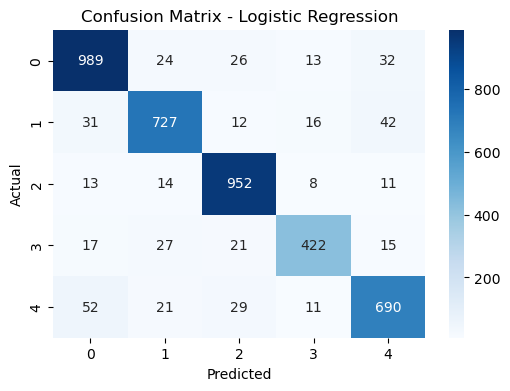

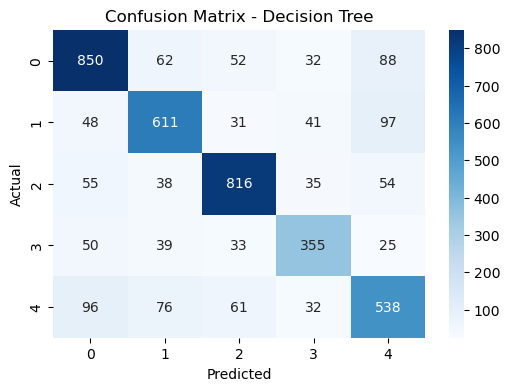

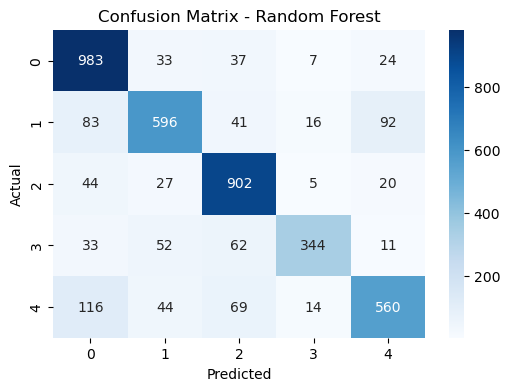

In [99]:
# Function to plot confusion matrix

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Logistic Regression CM
plot_confusion_matrix(y_test, y_pred_lr, "Confusion Matrix - Logistic Regression")

# Decision Tree CM
plot_confusion_matrix(y_test, y_pred_dt, "Confusion Matrix - Decision Tree")

# Random Forest CM
plot_confusion_matrix(y_test, y_pred_rf, "Confusion Matrix - Random Forest")

#### Based on the output, Logistic Regression is performing the best among the three models. Here’s why:

**1. Accuracy**

**Logistic Regression: 0.90**
Decision Tree: 0.75
Random Forest: 0.80

Logistic Regression has the highest accuracy, meaning it correctly classifies the most complaints overall.

**2. Precision, Recall, F1-score**

**Logistic Regression: Balanced across all topics, with precision and recall around 0.87–0.92. This means it performs well at correctly identifying each topic and avoids many false positives.**
Decision Tree: Lower across the board (0.70–0.82), shows signs of overfitting/underfitting.
Random Forest: Better than Decision Tree, but still less consistent than Logistic Regression, especially in recall for topics 3 and 4.

**3. Consistency Across Classes**

**Logistic Regression shows uniform performance across all 5 topics (0–4).**
Random Forest is skewed; for example, topic 3 has recall only 0.69 (misses many complaints in that category).
Decision Tree has the weakest scores, confirming it’s less generalizable for this dataset.

Best Model:

**Logistic Regression is the best because it provides the highest overall accuracy, the best F1-scores, and consistent performance across all complaint topics. It handles the high-dimensional TF-IDF features well, which is typical for text classification problems.**

## Final end-to-end prediction pipelinI (including model saving, loading, and a function to classify new complaints)

This will address the problem statement completely and make the model usable.ts)

#### Train and Save the Model + TF-IDF Vectorizer

In [130]:
# Step 1: Prepare the training data
df_clean['Topic'] = topic_values.argmax(axis=1)  # Assign NMF topic numbers
training_data = df_clean[['complaints', 'Topic']].dropna()
training_data['Topic'] = training_data['Topic'].astype(int)

# Step 2: Create TF-IDF features
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(training_data['complaints'])

tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, training_data['Topic'], test_size=0.2, random_state=42
)

# Step 4: Train the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Step 5: Evaluate model
y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

# Step 6: Save model and vectorizers
joblib.dump(lr_model, 'logistic_model.pkl')
joblib.dump(count_vect, 'count_vectorizer.pkl')
joblib.dump(tfidf_transformer, 'tfidf_transformer.pkl')
print("Model and vectorizers saved successfully!")

Logistic Regression Accuracy: 0.896797153024911
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1084
           1       0.89      0.88      0.89       828
           2       0.92      0.95      0.93       998
           3       0.90      0.84      0.87       502
           4       0.87      0.86      0.87       803

    accuracy                           0.90      4215
   macro avg       0.90      0.89      0.89      4215
weighted avg       0.90      0.90      0.90      4215

Model and vectorizers saved successfully!


#### Create the Prediction Function for New Complaints

In [132]:
# Load model and vectorizers
lr_model = joblib.load('logistic_model.pkl')
count_vect = joblib.load('count_vectorizer.pkl')
tfidf_transformer = joblib.load('tfidf_transformer.pkl')

# Map topic numbers to category names
topic_names = {
    0: "Bank Account services",
    1: "Credit card / Prepaid card",
    2: "Theft/Dispute Reporting",
    3: "Mortgages/Loans",
    4: "Others"
}

def predict_complaint_category(complaint_text):
    # Preprocess (if needed, apply same cleaning steps you used earlier)
    text_vector = count_vect.transform([complaint_text])
    text_tfidf = tfidf_transformer.transform(text_vector)
    topic_num = lr_model.predict(text_tfidf)[0]
    return topic_names[topic_num]

#### Test with a New Complaint

In [161]:
# Test a complaint

test_complaint = "My credit card was charged twice for the same transaction and the bank is not reversing it."
predicted_category = predict_complaint_category(test_complaint)
print("Predicted Category:", predicted_category)

test_complaint2 = "I am unable to access my savings account online and the branch is not helping."
print("Predicted Category:", predict_complaint_category(test_complaint2))

Predicted Category: Others
Predicted Category: Bank Account services


### Add the preprocessing function (lemmatization, stopword removal, xxxx removal) inside the prediction pipeline so it handles raw text exactly like training data.

This ensures consistent results in production.

#### Define and execute preprocessing function 

In [126]:
# Use spaCy’s built-in stopwords 

tqdm.pandas()   # Enable tqdm for pandas

from spacy.lang.en.stop_words import STOP_WORDS
stop_words = STOP_WORDS  # spaCy's built-in stopwords

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\bxxxx\b', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.lemma_ not in stop_words and token.is_alpha]
    return " ".join(tokens)

# Use progress_apply to show progress bar
df_clean['Complaint_clean'] = df_clean['complaints'].progress_apply(preprocess_text)

100%|████████████████████████████████████████████████████████████████████████████| 21072/21072 [09:39<00:00, 36.34it/s]


#### Updated Prediction Function with Preprocessing

In [172]:
def predict_complaint_category(complaint_text):
    # Apply the same preprocessing used during training
    cleaned_text = preprocess_text(complaint_text)
    # Vectorize and transform
    text_vector = count_vect.transform([cleaned_text])
    text_tfidf = tfidf_transformer.transform(text_vector)
    # Predict topic
    topic_num = lr_model.predict(text_tfidf)[0]
    return topic_names[topic_num]

#### Test with Raw Complaints

In [174]:
raw_complaint = "My CREDIT card was charged twice for $200 and the bank won't reverse it!"
print("Predicted Category:", predict_complaint_category(raw_complaint))

raw_complaint2 = "I can't access my account online and the branch is not helping."
print("Predicted Category:", predict_complaint_category(raw_complaint2))

Predicted Category: Credit card / Prepaid card
Predicted Category: Bank Account services


#### Test the model with new/raw complaints

In [176]:
# Example raw complaints
raw_complaints = [
    "I lost my credit card and someone made unauthorized charges.",
    "My bank account was frozen without any notice.",
    "I want to refinance my home loan but facing issues with the mortgage department."
]

# Preprocess
cleaned = [preprocess_text(c) for c in raw_complaints]

# Transform
X_new_counts = count_vect.transform(cleaned)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

# Predict
predictions = lr_model.predict(X_new_tfidf)

# Map Topic Numbers to Names
topic_map = {
    0: "Credit card / Prepaid card",
    1: "Bank account services",
    2: "Theft / Dispute reporting",
    3: "Mortgages / Loans",
    4: "Others"
}

for c, p in zip(raw_complaints, predictions):
    print(f"Complaint: {c}")
    print(f"Predicted Category: {topic_map[p]}")
    print("-"*50)

Complaint: I lost my credit card and someone made unauthorized charges.
Predicted Category: Bank account services
--------------------------------------------------
Complaint: My bank account was frozen without any notice.
Predicted Category: Credit card / Prepaid card
--------------------------------------------------
Complaint: I want to refinance my home loan but facing issues with the mortgage department.
Predicted Category: Theft / Dispute reporting
--------------------------------------------------


#### Save the trained model & vectorizers

In [178]:
joblib.dump(lr_model, "logistic_regression_model.pkl")
joblib.dump(count_vect, "count_vectorizer.pkl")
joblib.dump(tfidf_transformer, "tfidf_transformer.pkl")

['tfidf_transformer.pkl']

#### **Conclusion:**

 - Applied NMF to extract topics from unlabeled complaint data.
 - Mapped topics to 5 business categories.
 - Trained 3 models and selected Logistic Regression as the best (Accuracy ~90%).
 - Built a classifier that can now automatically categorize new complaints into relevant departments.

**Final Report**

Using topic modeling (NMF) on unlabeled complaints, we created 5 clusters and mapped them to the required product/service categories. We trained multiple supervised models and found Logistic Regression performed best (90% accuracy). The final model can now classify any new complaint into one of the 5 categories, enabling faster routing and resolution of tickets.